# Credit Card Segmentation

In [1]:
# Segmentation Models to work with
!pip install -U  segmentation-models

In [0]:
import tensorflow as tf
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## Segmentation

In order to detect and crop the credict card from the input image, we use a deep learning image segmentation approach. The resutls are limited given the little and low quality dataset used.

### Setting up enviroment

In [5]:
MY_DATA_DIR = './tdc_dataset/dataset'

# load repo with data if it is not exists
if not os.path.exists(MY_DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/micakce/tdc_segmentation_dataset ./tdc_dataset/dataset')
    print('Done!')

Loading data...
Done!


In [0]:
x_train_dir = os.path.join(MY_DATA_DIR, 'train')
y_train_dir = os.path.join(MY_DATA_DIR, 'trainannot')

# # # For the momento there is no validation data
# x_valid_dir = os.path.join(MY_DATA_DIR, 'valid')
# y_valid_dir = os.path.join(MY_DATA_DIR, 'validannot')



In [0]:
# Helper functions for data manipulation and visualization

def normalize(image):
  """Map images from -1..1 float 32 to 0--255 uint8"""
  image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  image = image.astype(np.uint8)
  return image
    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# Better column visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


# Function to crop image based on binary mask
def get_mask_crop(img,tol=0, mask=None):
    if mask is None:
        mask = img[...,0] > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

# do inference on the image and get cropped image based on predicted mask
def predict_and_crop(image, kernel_size=(20,20)):
  org_size = (image.shape[1], image.shape[0])
  sm_image=cv2.resize(image, (480,320))
  pr_mask=model.predict(sm_image[np.newaxis,...]).round()
  kernel = np.ones(kernel_size, np.uint8)
  pr_mask = cv2.erode(pr_mask.squeeze(), kernel, iterations=2)
  pr_mask = cv2.dilate(pr_mask, kernel, iterations=1)
  big_mask = cv2.resize(pr_mask, org_size)
  crop = get_mask_crop(image, mask=big_mask)
  crop = cv2.resize(crop, (960, 640))
  crop = normalize(crop)
  return crop, big_mask
    

# classes for data loading and preprocessing
class Dataset:
    """Read images, [apply augmentation] and preprocessing transformations.
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    
    CLASSES = ['card']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask != v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        # if self.preprocessing:
        #     sample = self.preprocessing(image=image, mask=mask)
        #     image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

    # If not using Dataloder, load the training set with this 
    def load(self):
      x, y = [],[]
      for i in range(len(self.ids)):
        image, mask = self.__getitem__(i)
        if self.preprocessing:
          image=self.preprocessing(image)
        x.append(image)
        y.append(mask)
      return np.asarray(x), np.asarray(y)

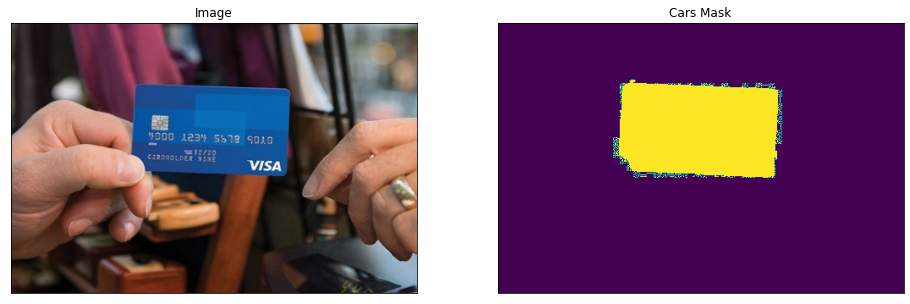

In [10]:
# Lets look at data we have
dataset = Dataset(x_train_dir,
                  y_train_dir,
                  classes=['card'],
                  )

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentation

Functions to use with Dataloder helper class to generate augmentation data at the same time the model is trained (Worked in the original notebook with TF V1, yet to implement here)



In [0]:
import albumentations as A

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [0]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['card'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze()
)

In [0]:
plt.figure(figsize=(20,20))
for i in range(0,58,2):
  image, mask = dataset[int(i/2)]
  plt.subplot(6,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image)
  plt.subplot(6,10,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(mask.squeeze())
plt.show()

### Model
Yo can build the model and train it yourself or go to the inference cell and use an already train model on the same data used here.

In [0]:
import segmentation_models as sm

# specify framework to work with, tf.keras for better compatibility
sm.set_framework('tf.keras')


In [0]:
# Define neural network parameters
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['card']
LR = 0.0001
EPOCHS = 40
# load corresponding model preprocessing
preprocess_input = sm.get_preprocessing(BACKBONE)

# case for binary and multiclass segmentation
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [0]:
# define model optimizer, loss function and metrics and compile
model.compile(
    tf.keras.optimizers.Adam(LR),
    loss = sm.losses.binary_focal_dice_loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
)

# We are ready to train!!

### Train


In [0]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    preprocessing=preprocess_input
)

x_train, y_train = train_dataset.load()

# #TODO Dataset for validation images
# valid_dataset = Dataset(
#     x_valid_dir, 
#     y_valid_dir, 
#     classes=CLASSES, 
#     preprocessing=preprocess_input
# )

# #TODO define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
#     keras.callbacks.ReduceLROnPlateau(),
# ]

In [0]:
# train model
history = model.fit(
  x=x_train,
  y=y_train,
  batch_size=5,
  epochs=20,
  callbacks=callbacks
)

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
scores = model.evaluate(x=x_test, y=y_test)

for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [0]:
# save arquitecture and weights
config = model.get_config()
weights = model.get_weights()

# Save JSON config to disk
json_config = model.to_json()
with open('</file/path/>', 'w') as json_file:
    json_file.write(json_config)

# Save weights to disk
model.save_weights('</file/paht>')

### Inference

Create the model and load the corresponding weights.

In [11]:
import segmentation_models as sm

sm.set_framework('tf.keras')

BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['card']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
44113920/44107200 [==============================] - 4s 0us/step


Mount your drive if you have your files there or download a previous trained model either going to drive or download with wget directly to the notebook

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [13]:
# drive link
trained_model = "https://drive.google.com/open?id=17F3mMYpDhMBcwmT67IEfZE8svIl1TFVp"

# download with wget
!wget "https://docs.google.com/uc?export=download&id=17F3mMYpDhMBcwmT67IEfZE8svIl1TFVp" -O tdc_segmentation_wights.h5



--2020-04-08 17:33:48--  https://docs.google.com/uc?export=download&id=17F3mMYpDhMBcwmT67IEfZE8svIl1TFVp
Resolving docs.google.com (docs.google.com)... 108.177.97.138, 108.177.97.139, 108.177.97.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qt3h1je4bb7pc09c8mm9ddth96u0fsv6/1586367225000/16476050985110878857/*/17F3mMYpDhMBcwmT67IEfZE8svIl1TFVp?e=download [following]
--2020-04-08 17:33:50--  https://doc-0g-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qt3h1je4bb7pc09c8mm9ddth96u0fsv6/1586367225000/16476050985110878857/*/17F3mMYpDhMBcwmT67IEfZE8svIl1TFVp?e=download
Resolving doc-0g-1k-docs.googleusercontent.com (doc-0g-1k-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to doc-0g-1k-docs.googleusercontent.com (doc-0g-1k-d

In [0]:

# # Reload the model from the 2 files we saved
# with open('/content/drive/My Drive/Credit Card Scanner/Models/20E_BestSoFar.json') as json_file:
#     json_config = json_file.read()
# new_model = keras.models.model_from_json(json_config)
model.load_weights('tdc_segmentation_weights.h5')

In [0]:
# Upload your tests picture to the test folder and set the paths.

x_test_dir = os.path.join(MY_DATA_DIR, 'test')
# in case you have the mask to compare results
y_test_dir = os.path.join(MY_DATA_DIR, 'testannot')



In [0]:
# load test set
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=['card'], 
    preprocessing=preprocess_input
)

x_test, y_test = test_dataset.load() 


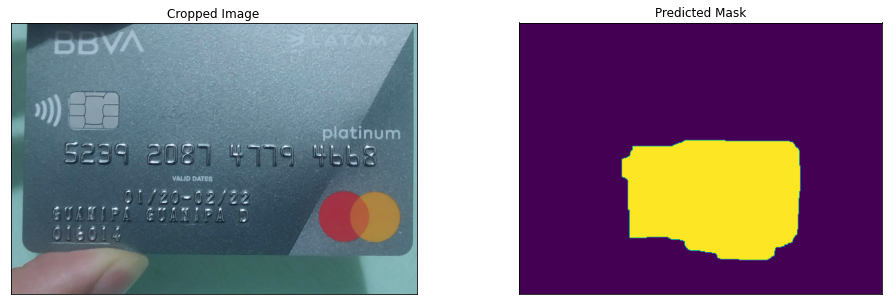

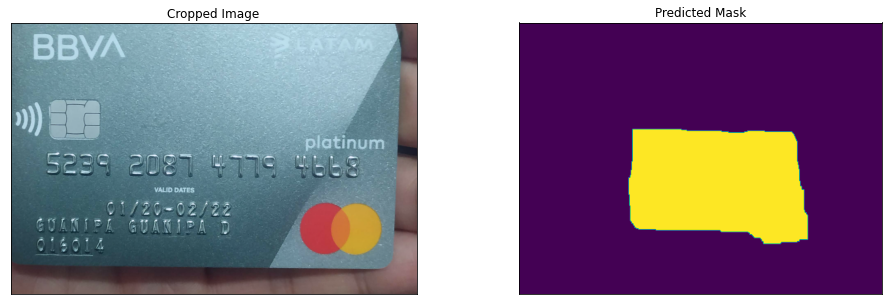

In [38]:
image, mask = predict_and_crop(x_test[1])
visualize(cropped_image=image, predicted_mask=mask)
image, mask = predict_and_crop(x_test[3])
visualize(cropped_image=image, predicted_mask=mask)
  

## OCR


### Text Detection

In [39]:
pip install --upgrade imutils

Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.3)


In [0]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2

In [47]:
# drive link
east = "https://drive.google.com/open?id=1c5-Ln5YQuwJ5ITKJoH5_A3TnQ4ebcJtE"

# download with wget, make sure path to this file is correct int detect_text function (cv2.dnn.readNet)
!wget "https://docs.google.com/uc?export=download&id=1c5-Ln5YQuwJ5ITKJoH5_A3TnQ4ebcJtE" -O frozen_east_text_detection.pb 

--2020-04-08 18:05:49--  https://docs.google.com/uc?export=download&id=1c5-Ln5YQuwJ5ITKJoH5_A3TnQ4ebcJtE
Resolving docs.google.com (docs.google.com)... 74.125.203.139, 74.125.203.101, 74.125.203.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/58ul2t1lbnsr094c1e4b9bu56vh7ih5l/1586369100000/16476050985110878857/*/1c5-Ln5YQuwJ5ITKJoH5_A3TnQ4ebcJtE?e=download [following]
--2020-04-08 18:05:55--  https://doc-0o-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/58ul2t1lbnsr094c1e4b9bu56vh7ih5l/1586369100000/16476050985110878857/*/1c5-Ln5YQuwJ5ITKJoH5_A3TnQ4ebcJtE?e=download
Resolving doc-0o-1k-docs.googleusercontent.com (doc-0o-1k-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to doc-0o-1k-docs.googleusercontent.com (doc-0o-1k-d

In [0]:
def detect_text(image, resize=(480,320), min_score=0.5, padding=0.0):
  """ Take input image, resize, proccess, detect text and draw corresponding boxes
     image: Input image
     resize: dimensions to resize the image and work with (must be multiple of 32)
     min_confidence: minimum score for boxes to take into account
     padding: extra padding for boxes 0.10=10%
  """ 
  # load the input image and grab the image dimensions
  image = image
  orig = image.copy()
  (origH, origW) = image.shape[:2]
  # set the new width and height and then determine the ratio in change
  # for both the width and height
  (newW, newH) = resize
  rW = origW / float(newW)
  rH = origH / float(newH)
  # resize the image and grab the new image dimensions
  image = cv2.resize(image, (newW, newH))
  (H, W) = image.shape[:2]
  
  # define the two output layer names for the EAST detector model that
  # we are interested -- the first is the output probabilities and the
  # second can be used to derive the bounding box coordinates of text
  layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]
  
  
  # load the pre-trained EAST text detector
  print("[INFO] loading EAST text detector...")
  net = cv2.dnn.readNet("frozen_east_text_detection.pb")
  # construct a blob from the image and then perform a forward pass of
  # the model to obtain the two output layer sets
  blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    (123.68, 116.78, 103.94), swapRB=True, crop=False)
  start = time.time()
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)
  end = time.time()
  # show timing information on text prediction
  print("[INFO] text detection took {:.6f} seconds".format(end - start))
  
  # grab the number of rows and columns from the scores volume, then
  # initialize our set of bounding box rectangles and corresponding
  # confidence scores
  (numRows, numCols) = scores.shape[2:4]
  rects = []
  confidences = []
  # loop over the number of rows
  for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
  
  # loop over the number of columns
    for x in range(0, numCols):
      # if our score does not have sufficient probability, ignore it
      if scoresData[x] < min_score:
        continue
      # compute the offset factor as our resulting feature maps will
      # be 4x smaller than the input image
      (offsetX, offsetY) = (x * 4.0, y * 4.0)
      # extract the rotation angle for the prediction and then
      # compute the sin and cosine
      angle = anglesData[x]
      cos = np.cos(angle)
      sin = np.sin(angle)
      # use the geometry volume to derive the width and height of
      # the bounding box
      h = xData0[x] + xData2[x]
      w = xData1[x] + xData3[x]
      # compute both the starting and ending (x, y)-coordinates for
      # the text prediction bounding box
      endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
      endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
      startX = int(endX - w)
      startY = int(endY - h)
      # add the bounding box coordinates and probability score to
      # our respective lists
      rects.append((startX, startY, endX, endY))
      confidences.append(scoresData[x])
  
  
  # apply non-maxima suppression to suppress weak, overlapping bounding
  # boxes
  boxes = non_max_suppression(np.array(rects), probs=confidences)
  # loop over the bounding boxes
  for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((endX - startX) * padding)
    dY = int((endY - startY) * padding)
  	# apply padding to each side of the bounding box, respectively
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
  # show the output image
  plt.imshow(orig)

[INFO] loading EAST text detector...
[INFO] text detection took 0.795337 seconds


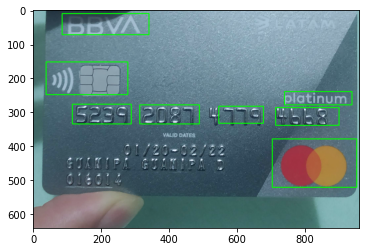

In [49]:
imagine, _ = predict_and_crop(x_test[1])
detect_text(imagine, padding=0.05)

### Text Recongnition

In [50]:
# Install and import neccessary packages packages
!sudo apt install tesseract-ocr
!tesseract -v

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,468 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [51]:
!pip install pillow
!pip install pytesseract
!pip install imutils

  Created wheel for pytesseract: filename=pytesseract-0.3.3-py2.py3-none-any.whl size=13396 sha256=fa57b3adefa0feda2348c3685077d5f7f07d2a49a9bfbe099823895de8cc0a20
  Stored in directory: /root/.cache/pip/wheels/82/1a/d0/a884540a5602305f5bb7ff44f05550be20453edce8fae69241
Successfully built pytesseract


In [0]:
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse
import cv2

In [0]:


def recognize_text(image, resize=(480,320), min_confidence=0.5, padding=0.0):
  """ Take input image, resize, proccess, detect and recognize text and draw corresponding boxes
      image: Input image
      resize: dimensions to resize and work with (must be multiple of 32)
      min_confidence: minimum score for boxes to take into account
      padding: extra padding for boxes 0.10=10%
   """
  def decode_predictions(scores, geometry):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
  
    # loop over the number of rows
    for y in range(0, numRows):
      # extract the scores (probabilities), followed by the
      # geometrical data used to derive potential bounding box
      # coordinates that surround text
      scoresData = scores[0, 0, y]
      xData0 = geometry[0, 0, y]
      xData1 = geometry[0, 1, y]
      xData2 = geometry[0, 2, y]
      xData3 = geometry[0, 3, y]
      anglesData = geometry[0, 4, y]
  
      # loop over the number of columns
      for x in range(0, numCols):
        # if our score does not have sufficient probability,
        # ignore it
        if scoresData[x] < min_confidence:
          continue
  
        # compute the offset factor as our resulting feature
        # maps will be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
  
        # extract the rotation angle for the prediction and
        # then compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
  
        # use the geometry volume to derive the width and height
        # of the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
  
        # compute both the starting and ending (x, y)-coordinates
        # for the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
  
        # add the bounding box coordinates and probability score
        # to our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])
  
    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)
  
  # load the input image and grab the image dimensions
  orig = image.copy()
  (origH, origW) = image.shape[:2]
  
  # set the new width and height and then determine the ratio in change
  # for both the width and height
  (newW, newH) = resize 
  rW = origW / float(newW)
  rH = origH / float(newH)
  
  # resize the image and grab the new image dimensions
  image = cv2.resize(image, (newW, newH))
  (H, W) = image.shape[:2]
  
  # define the two output layer names for the EAST detector model that
  # we are interested -- the first is the output probabilities and the
  # second can be used to derive the bounding box coordinates of text
  layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]
  
  # load the pre-trained EAST text detector
  print("[INFO] loading EAST text detector...")
  net = cv2.dnn.readNet("frozen_east_text_detection.pb")
  
  # construct a blob from the image and then perform a forward pass of
  # the model to obtain the two output layer sets
  blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    (123.68, 116.78, 103.94), swapRB=True, crop=False)
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)
  
  # decode the predictions, then  apply non-maxima suppression to
  # suppress weak, overlapping bounding boxes
  (rects, confidences) = decode_predictions(scores, geometry)
  boxes = non_max_suppression(np.array(rects), probs=confidences)
  
  # initialize the list of results
  results = []
  
  # loop over the bounding boxes
  for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
  
    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((endX - startX) * padding)
    dY = int((endY - startY) * padding)
  
    # apply padding to each side of the bounding box, respectively
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))
  
    # extract the actual padded ROI
    roi = orig[startY:endY, startX:endX]
  
    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)
  
    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((startX, startY, endX, endY), text))
  
  # sort the results bounding box coordinates from top to bottom
  results = sorted(results, key=lambda r:r[0][1])
  
  # loop over the results
  n=len(results)
  plt.figure(figsize=(60,40))
  for i,((startX, startY, endX, endY), text) in enumerate(results):
    # display the text OCR'd by Tesseract
    # print("OCR TEXT")
    # print("========")
    # print("{}\n".format(text))
  
    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding
    # the text region of the input image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    output = orig.copy()
    cv2.rectangle(output, (startX, startY), (endX, endY),
      (0, 0, 255), 2)
    cv2.putText(output, text, (startX, startY - 20),
      cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
    plt.subplot(int(n/3) +1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(text)
    plt.imshow(output)
  plt.show()

[INFO] loading EAST text detector...


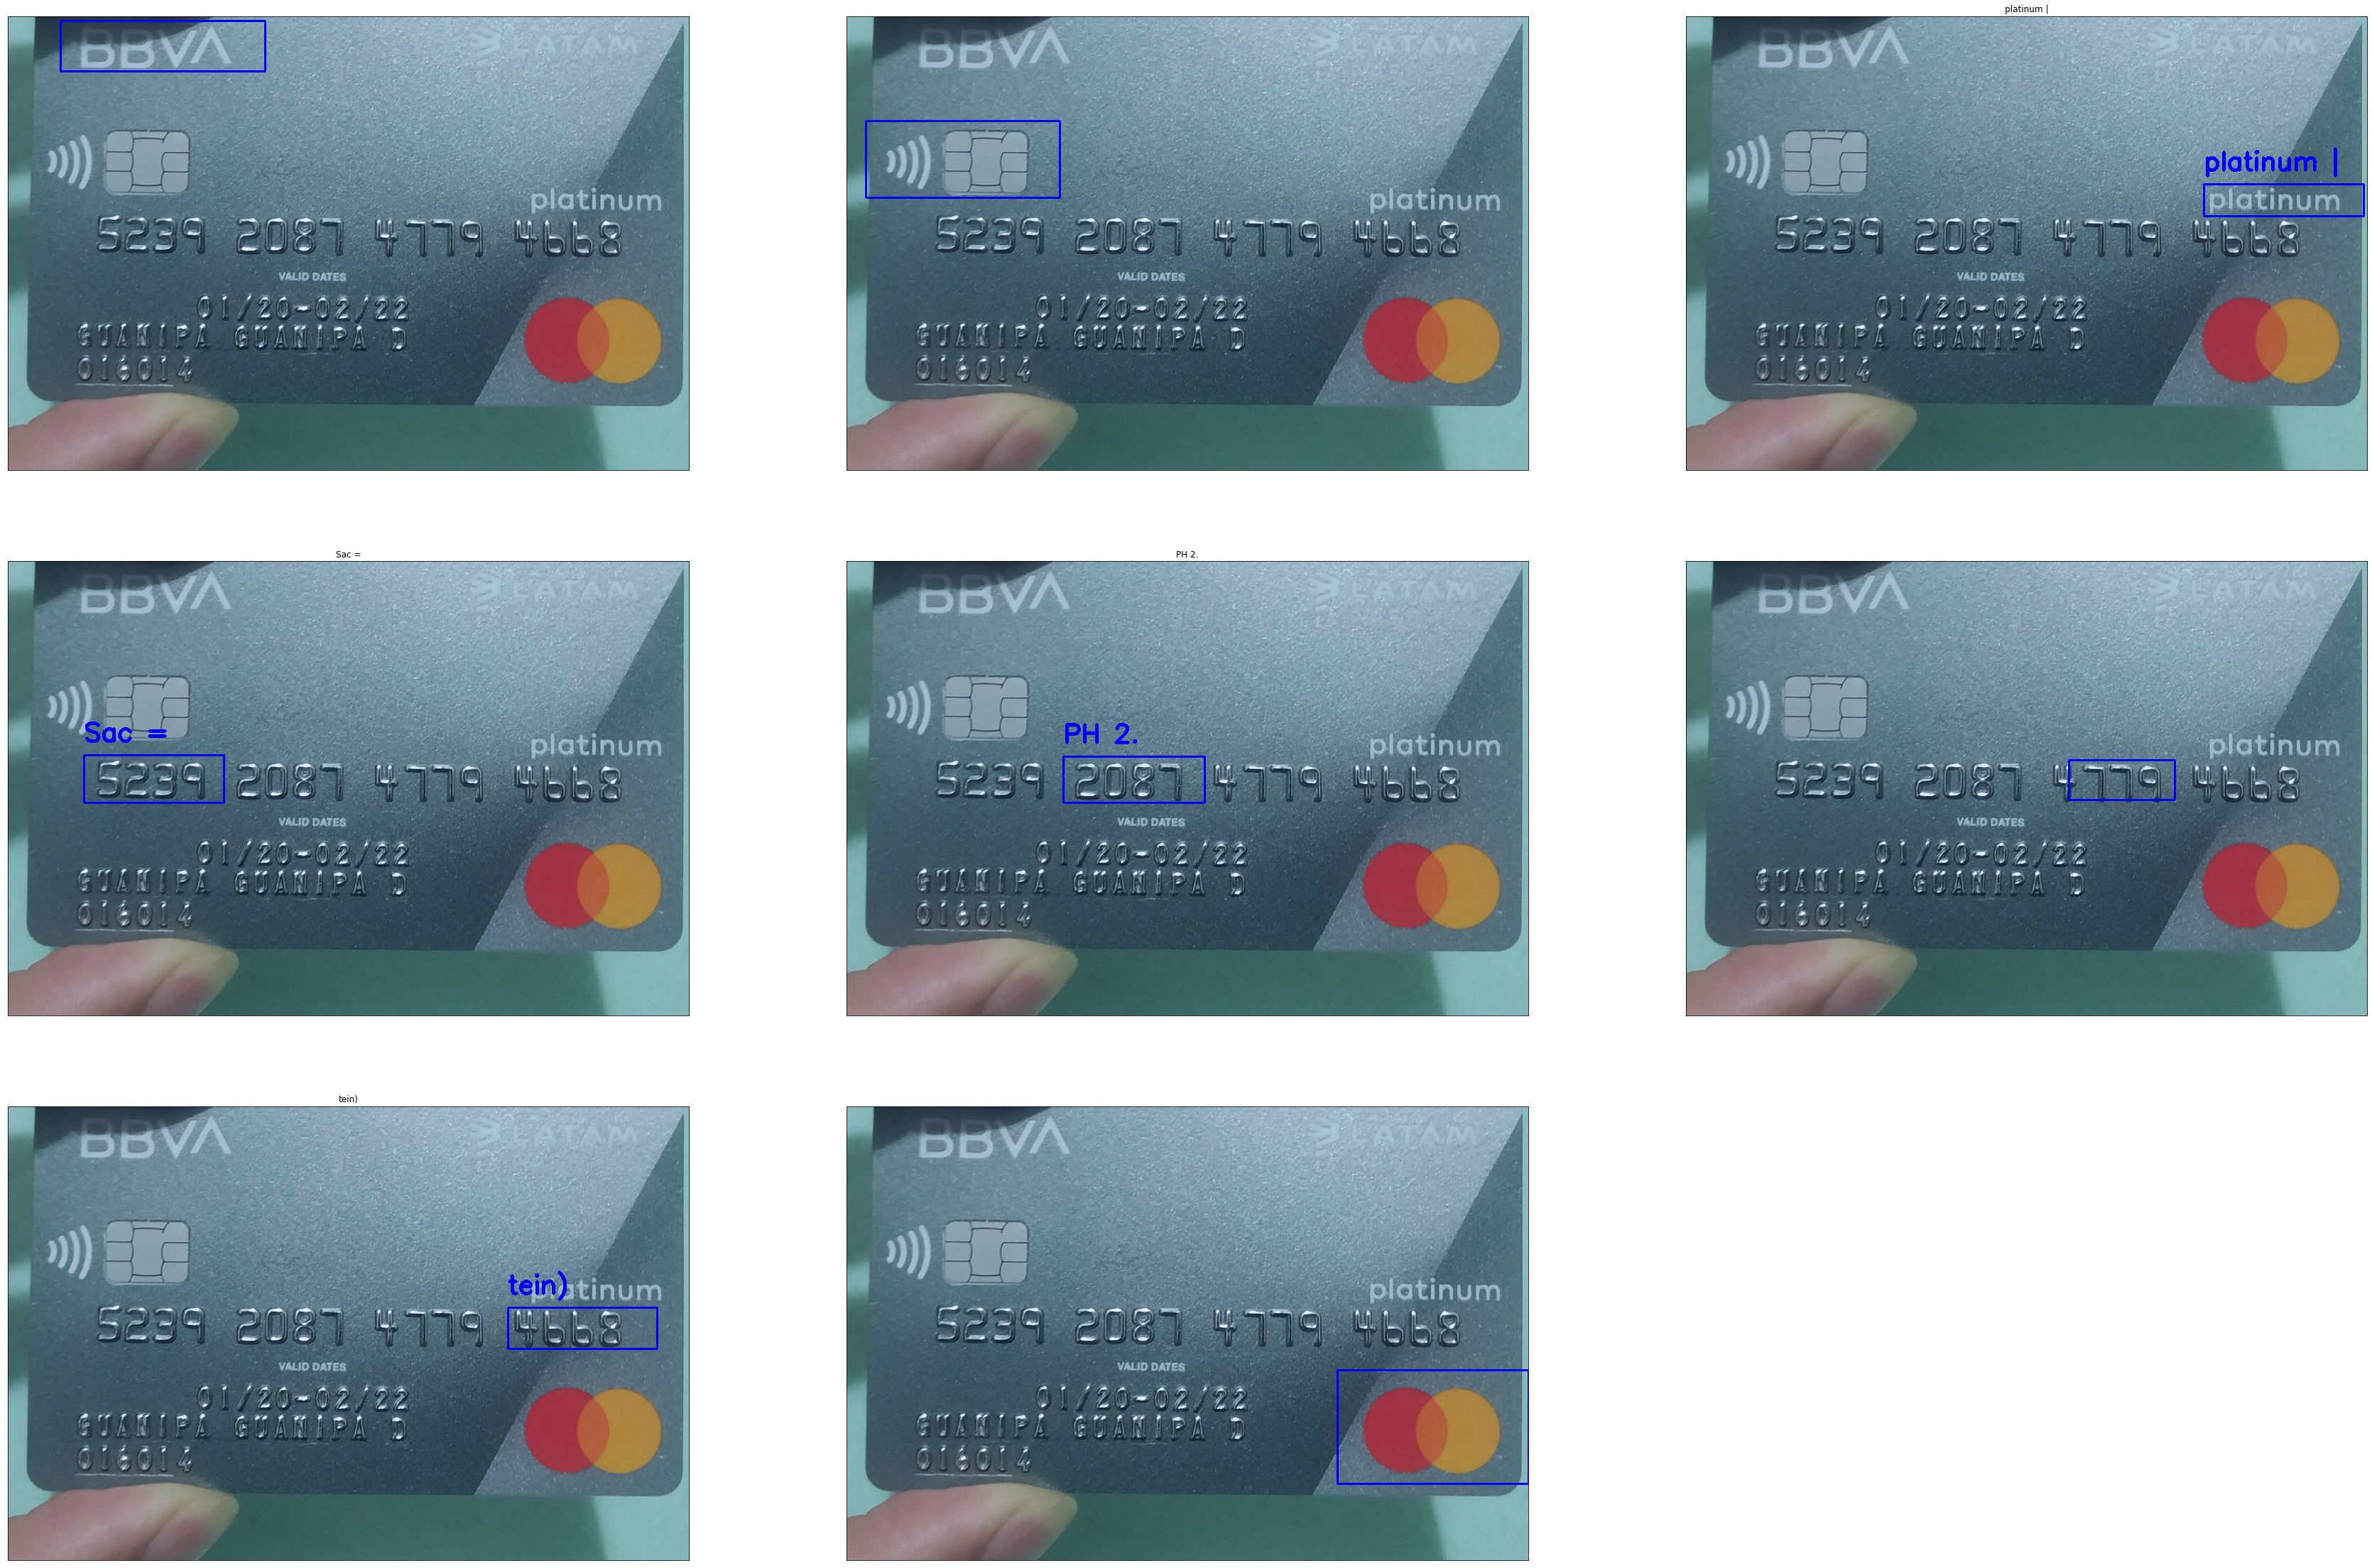

In [58]:
image, _ = predict_and_crop(x_test[1])
recognize_text(image, padding=0.10)

## Conclusions

Given the little data there is to train, the model did a good job predicting the masks, it shouldn't be hard to train it further on more data and get much better results. On the other hand, even though a life images text recognition approach was used, the results weren't any good, that is given the complexity of text we can find in real life objects, and it makes sense credict cards are not taken that much into account when building this kind of models. A lot of work to do on the text detection and recognition part.

## Referencias.

- Segmentation: Is based on the CamVid example in the respository [qubvel/segmentation_models](https://github.com/qubvel/segmentation_models)
- OCR: Is a Colab adaptation from Adrian Rosebrock implementations, more on these two posts: [opencv-text-detection-east-text-detector](https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/) and [opencv-ocr-and-text-recognition-with-tesseract](https://www.pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/).